In [103]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier as knnc

import torch
import torchvision
import torchvision.transforms as transforms

import material.cifar10 as cifar10

In [4]:
# cifar10 = cifar10.load_CIFAR10()

In [5]:
# pytorch version
trainset = torchvision.datasets.CIFAR10(root='./data_pytorch', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data_pytorch', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# slight abuse of the dataloaders to get the desired size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10000, shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=5000, shuffle=False, num_workers=0)

In [119]:
class Dataset:
    # small class to convert from pytorch dimension order to sklearn
    def __init__(self, loader):
        # input is a pytorch loader
        self.loader = loader
        self.x, self.y = iter(self.loader).next()
        self.pred = None
        
        # change dimension order (from NCHW to NHWC)
        self.x = self.x.permute(0, 2, 3, 1)
    
    def skl(self):
        # get output for sklearn algorithm (flatten)
        
        x = self.x.contiguous().view(self.x.size(0), -1).numpy()
        y = self.y.numpy()
        
        return x, y

In [120]:
trainset = Dataset(trainloader)
testset = Dataset(testloader)

print(trainset.x.shape)
print(trainset.y.shape)

torch.Size([10000, 32, 32, 3])
torch.Size([10000])


# Train and fit witha kNN 

## n = 1

In [42]:
# set up the k nn classifier
knn_1 = knnc(n_neighbors=1, n_jobs=-1)
# use the .skl method
knn_1.fit(*trainset.skl())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

In [45]:
# prediction time
testset.pred = knn_1.predict(testset.skl()[0])
print("Accuracy: {}".format(acc(testset.y, testset.pred)))

Accuracy: 0.2868


## n = 16

In [46]:
# set up the k nn classifier
knn_16 = knnc(n_neighbors=16, n_jobs=-1)
knn_16.fit(*trainset.skl())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

In [47]:
testset.pred = knn_16.predict(testset.skl()[0])
print("Accuracy: {}".format(acc(testset.y, testset.pred)))

Accuracy: 0.294


## n = 64

In [48]:
# set up the k nn classifier
knn_64 = knnc(n_neighbors=64, n_jobs=-1)
knn_64.fit(*trainset.skl())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

In [49]:
testset.pred = knn_64.predict(testset.skl()[0])
print("Accuracy: {}".format(acc(testset.y, testset.pred)))

Accuracy: 0.2804


None of the results allow to scientifically argue that one of the choices of n is superior to the others.

In [113]:
class FeatureExtraction:
    def __init__(self):
        # pytorch dataset goes from 0 to 1, not 0 to 255
        self.edges = np.linspace(0, 1, 10+1)
    

    def get_features(self, img):
        red, _ = np.histogram(img[:, :, 0].flatten(), self.edges)
        green, _ = np.histogram(img[:, :, 1].flatten(), self.edges)
        blue, _ = np.histogram(img[:, :, 2].flatten(), self.edges)
        
        return np.concatenate([red, blue, green]).reshape([1, -1])
    
    def foward(self, dataset):
        dlen = dataset.x.shape[0]
        features = np.empty((dlen, 30))
        
        for i in range(dlen):
            features[i, :] = self.get_features(dataset.x[i, :, :, :])
            
        dataset.features = features
        
        return dataset
        
    

In [110]:
trainset_feat = FeatureExtraction().foward(trainset)
testset_feat = FeatureExtraction().foward(testset)

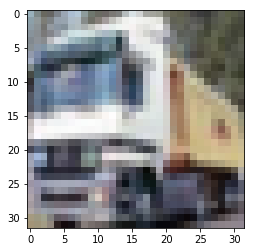

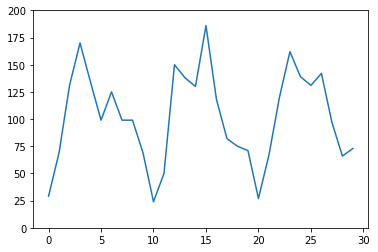

In [111]:
plt.imshow(trainset_feat.x[1]); plt.show()
plt.plot(trainset_feat.features[1, :]); plt.ylim(0, 200); plt.show()

In [117]:
## n = 1

# set up the k nn classifier
knn_1 = knnc(n_neighbors=1, n_jobs=-1)
knn_1.fit(trainset.features, trainset.y)

# prediction time
testset.pred = knn_1.predict(testset.features)
print("Accuracy of  n = 1: {}".format(acc(testset.y, testset.pred)))

## n = 16

# set up the k nn classifier
knn_16 = knnc(n_neighbors=16, n_jobs=-1)
knn_16.fit(trainset.features, trainset.y)

testset.pred = knn_16.predict(testset.features)
print("Accuracy of n = 16: {}".format(acc(testset.y, testset.pred)))

## n = 64

# set up the k nn classifier
knn_64 = knnc(n_neighbors=64, n_jobs=-1)
knn_64.fit(trainset.features, trainset.y)

testset.pred = knn_64.predict(testset.features)
print("Accuracy of n = 64: {}".format(acc(testset.y, testset.pred)))

Accuracy of  n = 1: 0.2518
Accuracy of n = 16: 0.2826
Accuracy of n = 64: 0.291


None of the results allow to scientifically argue that one of the choices of n is superior to the others. There does not seem to be a huge effect of extracting the features (which is not too bad, since with the features the dimensionality is only d = 30 and not d = 32 * 32).